This notebook is designed to run in a IBM Watson Studio default runtime (NOT the Watson Studio Apache Spark Runtime as the default runtime with 1 vCPU is free of charge). Therefore, we install Apache Spark in local mode for test purposes only. Please don't use it in production.

In case you are facing issues, please read the following two documents first:

https://github.com/IBM/skillsnetwork/wiki/Environment-Setup

https://github.com/IBM/skillsnetwork/wiki/FAQ

Then, please feel free to ask:

https://coursera.org/learn/machine-learning-big-data-apache-spark/discussions/all

Please make sure to follow the guidelines before asking a question:

https://github.com/IBM/skillsnetwork/wiki/FAQ#im-feeling-lost-and-confused-please-help-me


If running outside Watson Studio, this should work as well. In case you are running in an Apache Spark context outside Watson Studio, please remove the Apache Spark setup in the first notebook cells.

In [1]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))


if ('sc' in locals() or 'sc' in globals()):
    printmd('<<<<<!!!!! It seems that you are running in a IBM Watson Studio Apache Spark Notebook. Please run it in an IBM Watson Studio Default Runtime (without Apache Spark) !!!!!>>>>>')


In [2]:
!pip install pyspark==2.4.5

In [3]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')

In [4]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

Welcome to exercise two of week three of “Apache Spark for Scalable Machine Learning on BigData”. In this exercise we’ll work on clustering.

Let’s create our DataFrame again:


In [5]:
# delete files from previous runs
!rm -f hmp.parquet*

# download the file containing the data in PARQUET format
!wget https://github.com/IBM/coursera/raw/master/hmp.parquet
    
# create a dataframe out of it
df = spark.read.parquet('hmp.parquet')

# register a corresponding query table
df.createOrReplaceTempView('df')

--2020-08-15 13:12:15--  https://github.com/IBM/coursera/raw/master/hmp.parquet
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/raw/master/hmp.parquet [following]
--2020-08-15 13:12:16--  https://github.com/IBM/skillsnetwork/raw/master/hmp.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/hmp.parquet [following]
--2020-08-15 13:12:16--  https://raw.githubusercontent.com/IBM/skillsnetwork/master/hmp.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.192.133, 151.101.128.133, 151.101.64.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.192.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 932997

Let’s reuse our feature engineering pipeline.

In [6]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, Normalizer
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline

indexer = StringIndexer(inputCol="class", outputCol="classIndex")
encoder = OneHotEncoder(inputCol="classIndex", outputCol="categoryVec")
vectorAssembler = VectorAssembler(inputCols=["x","y","z"],
                                  outputCol="features")
normalizer = Normalizer(inputCol="features", outputCol="features_norm", p=1.0)

pipeline = Pipeline(stages=[indexer, encoder, vectorAssembler, normalizer])
model = pipeline.fit(df)
prediction = model.transform(df)
prediction.show()

+---+---+---+--------------------+-----------+----------+--------------+----------------+--------------------+
|  x|  y|  z|              source|      class|classIndex|   categoryVec|        features|       features_norm|
+---+---+---+--------------------+-----------+----------+--------------+----------------+--------------------+
| 22| 49| 35|Accelerometer-201...|Brush_teeth|       6.0|(13,[6],[1.0])|[22.0,49.0,35.0]|[0.20754716981132...|
| 22| 49| 35|Accelerometer-201...|Brush_teeth|       6.0|(13,[6],[1.0])|[22.0,49.0,35.0]|[0.20754716981132...|
| 22| 52| 35|Accelerometer-201...|Brush_teeth|       6.0|(13,[6],[1.0])|[22.0,52.0,35.0]|[0.20183486238532...|
| 22| 52| 35|Accelerometer-201...|Brush_teeth|       6.0|(13,[6],[1.0])|[22.0,52.0,35.0]|[0.20183486238532...|
| 21| 52| 34|Accelerometer-201...|Brush_teeth|       6.0|(13,[6],[1.0])|[21.0,52.0,34.0]|[0.19626168224299...|
| 22| 51| 34|Accelerometer-201...|Brush_teeth|       6.0|(13,[6],[1.0])|[22.0,51.0,34.0]|[0.20560747663551...|
|

Now let’s create a new pipeline for kmeans.

In [10]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans(featuresCol="features").setK(14).setSeed(1)
pipeline = Pipeline(stages=[vectorAssembler, kmeans])
model = pipeline.fit(df)
predictions = model.transform(df)

evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.41244594513295846


We have 14 different movement patterns in the dataset, so setting K of KMeans to 14 is a good idea. But please experiment with different values for K, do you find a sweet spot? The closer Silhouette gets to 1, the better.

https://en.wikipedia.org/wiki/Silhouette_(clustering)


In [21]:
# please change the pipeline the check performance for different K, feel free to use a loop
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
res = []
r = range(8, 16)
for k in r:
    kmeans = KMeans(featuresCol="features").setK(k).setSeed(1)
    pipeline = Pipeline(stages=[vectorAssembler, kmeans])
    model = pipeline.fit(df)
    predictions = model.transform(df)

    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
    res.append(silhouette)

In [22]:
%matplotlib inline

Text(0, 0.5, 'silhouette')

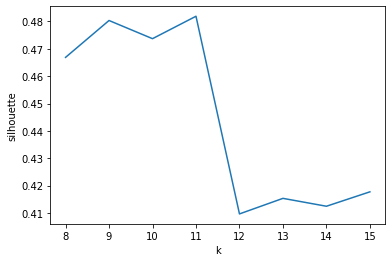

In [23]:
import matplotlib.pyplot as plt
plt.plot(list(r), res)
plt.xlabel("k")
plt.ylabel("silhouette")

Now please extend the pipeline to work on the normalized features. You need to tell KMeans to use the normalized feature column and change the pipeline in order to contain the normalizer stage as well.

In [25]:
kmeans = KMeans(featuresCol="features_norm").setK(14).setSeed(1)
pipeline = Pipeline(stages=[vectorAssembler, normalizer, kmeans])
model = pipeline.fit(df)

predictions = model.transform(df)

evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))


Silhouette with squared euclidean distance = 0.2668998965895519


Sometimes, inflating the dataset helps, here we multiply x by 10, let’s see if the performance inceases.

In [26]:
from pyspark.sql.functions import col
df_denormalized = df.select([col('*'),(col('x')*10)]).drop('x').withColumnRenamed('(x * 10)','x')

In [27]:
kmeans = KMeans(featuresCol="features").setK(14).setSeed(1)
pipeline = Pipeline(stages=[vectorAssembler, kmeans])
model = pipeline.fit(df_denormalized)
predictions = model.transform(df_denormalized)

evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.5709023393004293


Apache SparkML can be used to try many different algorithms and parametrizations using the same pipeline. Please change the code below to use GaussianMixture over KMeans. Please use the following link for your reference.

https://spark.apache.org/docs/latest/ml-clustering.html#gaussian-mixture-model-gmm


In [ ]:
from pyspark.ml.clustering import GaussianMixture

gmm = GaussianMixture(featuresCol="features_norm").setK(14).setSeed(538009335)
pipeline = Pipeline(stages=[vectorAssembler, normalizer, gmm])

model = pipeline.fit(df)

predictions = model.transform(df)

evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))